## CSUS - CSC 177-02 Data Warehousing and Data Mining - Project 1: Clustering  
### 2016 U.S. presidential election Twitter analysis  

**Group members: Aaron Enberg, Nima Sarrafzadeh, Kyne Liu**  
**Professor: Haiquan (Victor) Chen**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import (
    preprocessing,  
    cluster as sk_cluster,
    metrics as metrics
)
from sklearn.feature_selection import VarianceThreshold
import sklearn.feature_extraction.text as sk_text
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

In [5]:
column_names = ['name', 'screen_name', 'user_id', 
                'followers_count', 'friends_count', 
                'location', 'description', 'created_at', 
                'status_id', 'language', 'place', 
                'retweet_count', 'favorite_count', 'text']

tweets = pd.read_table('data/clinton_trump_tweets.txt', names=column_names, encoding='ISO-8859-1')

In [6]:
print(tweets.shape)
print(tweets.dtypes)

(5250980, 14)
name               object
screen_name        object
user_id            int64 
followers_count    int64 
friends_count      int64 
location           object
description        object
created_at         object
status_id          int64 
language           object
place              object
retweet_count      int64 
favorite_count     int64 
text               object
dtype: object


## Preprocessing

In [7]:
tweets.drop(['name', 'screen_name', 
            'followers_count', 
            'friends_count', 
            'location', 
            'description', 
            'created_at',
            'status_id', 
            'language', 
            'place', 
            'retweet_count', 
            'favorite_count'], axis=1, inplace=True)

tweets.head()

,user_id,text
0,1519696717,@NWAJimmy I've read it now though brother. Was pretty spot on Lots of bright spots but a lot to work on. Exactly as an exhibition should be!
1,109945090,RT @wikileaks: New poll puts Pirate Party on course to win Iceland's national elections on Saturday. https://t.co/edTqjeJaQ6
2,1450086582,@gaystoner821 I think New Orleans spoiled me with food. I need to try and branch out in BR.
3,167177185,RT @LOLGOP: ACA needs fixes but know da facts: *70% can get covered in marketplaces for under $75/month *Hikes affect 3% *GOP will uninsu
4,1191022351,RT @FastCompany: Alphabet shares soar on better-than-expected earnings as mobile video strategy pays off https://t.co/bokbXngMJt https://t.


### Remove all retweets

In [8]:
# lines that start with "RT" followed by a space
pattern = r'^RT\s'
 
# matches retweets and removes them
tweets = tweets[tweets.text.str.match(pattern) == False]

In [9]:
tweets.shape

(2416818, 2)

### Extract all handles and hashtags

In [10]:
# match all hashtags and handles in a tweet, ignoring possible email addresses
pattern = r'(?<=^|(?<=[^a-zA-Z0-9-\.]))@([A-Za-z_]+[A-Za-z0-9_]+)|(?<=^|(?<=[^a-zA-Z0-9-\.]))#([A-Za-z_]+[A-Za-z0-9_]+)'

""" returns a DataFrame with a MultiIndex:
    First index is our original index. Second index is "match" which is a running
    total of the number of occurences of hashtags and mentions for a particular 
    tweet. """
handles_hashtags = tweets.text.str.extractall(pattern)

# make the dataframe look nice 
handles_hashtags.columns = ['handles', 'hashtags']
handles_hashtags = handles_hashtags.reset_index().set_index('level_0')
del handles_hashtags.index.name
handles_hashtags.drop(['match'], axis=1, inplace=True)

# stack handles and hashtags into one column
handles_hashtags = pd.concat([handles_hashtags.handles, handles_hashtags.hashtags]).dropna().to_frame(name='handles_hashtags')

tweets = tweets.join(handles_hashtags, how='inner').reset_index()
tweets.drop(['text'], axis=1, inplace=True)

In [11]:
tweets.head(n=10)

,index,user_id,handles_hashtags
0,0,1519696717,NWAJimmy
1,2,1450086582,gaystoner821
2,6,106568768,infosec
3,6,106568768,Intel
4,6,106568768,ACM
5,6,106568768,IEEE
6,12,163712593,Haylie_Bre
7,13,2447279666,WayneDupreeShow
8,13,2447279666,climatechange
9,22,111679943,tansleyemiley69


### keep active users with at least 20 distinct hashtags/handles

In [12]:
# returns users along with the distinct hashtags/handles they've used
handles_hashtags_distinct = tweets.groupby('user_id')['handles_hashtags'].unique().to_frame()
# retrieve only those who have used 20 or more distinct handles/hashtags
users_active = handles_hashtags_distinct[handles_hashtags_distinct.handles_hashtags.str.len() > 19]

In [13]:
''' returns users along with all the hashtags and handles (including duplicates) they've used 
    (each occurrence of a hashtag/handle will also show up in the list) '''
handles_hashtags_all = tweets.reset_index().groupby('user_id')['handles_hashtags'].apply(list).to_frame()

users_active = users_active.join(handles_hashtags_all, lsuffix='_distinct', rsuffix='_all', how='inner')

In [14]:
users_active.head()

,handles_hashtags_distinct,handles_hashtags_all
user_id,,
1644,"[MaryLovesBooks, BookNerdParadis, matt_hearnden, success, perspective, life, CodyBLister, Marketing, nick_eubanks, contentmarketing, promotionftw, fredrivett, RobWormley, ContentMarketing, LArtra, adamjayc, bloggingwizard, GuestBloggingStrategy, TamieDearen, JRRTolkien, KatyHuthJones, LorilynRoberts, _awtozer, rahdieh, TolkienQuote, EliseKova, startrailsIV, FebruaryGrace, rtmixmktg, raecarson, WillBluntAU, blog, LaurenLynneYA, listbuilding, guestposting, motivation, emailmarketing, CRO]","[MaryLovesBooks, BookNerdParadis, matt_hearnden, success, perspective, life, CodyBLister, Marketing, nick_eubanks, contentmarketing, promotionftw, contentmarketing, fredrivett, RobWormley, ContentMarketing, LArtra, BookNerdParadis, adamjayc, bloggingwizard, GuestBloggingStrategy, TamieDearen, BookNerdParadis, JRRTolkien, KatyHuthJones, BookNerdParadis, LorilynRoberts, BookNerdParadis, _awtozer, rahdieh, BookNerdParadis, TolkienQuote, EliseKova, BookNerdParadis, startrailsIV, BookNerdParadis, FebruaryGrace, BookNerdParadis, rtmixmktg, raecarson, BookNerdParadis, WillBluntAU, ContentMarketing, blog, LaurenLynneYA, BookNerdParadis, listbuilding, guestposting, motivation, success, emailmarketing, CRO]"
1737,"[nehanarkhede, ATO2016, erinscafe, MailChimp, rachaelmaddux, _raven_io, pwnela, GregU, PTC, Vuforia, salrelish, KyFaSt, SwiftOnSecurity, dcloues, jessfraz, solrac901, ApacheSpot, adickerson, ComfortablySmug, jdickerson, skamille, Michael_Tsunam1, samnesmith, bakins, JessicaMauerhan]","[nehanarkhede, ATO2016, erinscafe, MailChimp, ATO2016, rachaelmaddux, _raven_io, pwnela, GregU, PTC, Vuforia, ATO2016, nehanarkhede, erinscafe, salrelish, KyFaSt, nehanarkhede, MailChimp, ATO2016, SwiftOnSecurity, dcloues, nehanarkhede, jessfraz, erinscafe, nehanarkhede, solrac901, ApacheSpot, MailChimp, ATO2016, adickerson, ComfortablySmug, jdickerson, skamille, Michael_Tsunam1, samnesmith, bakins, JessicaMauerhan]"
2391,"[NathanFGao, bonaventuresoft, presserb, petshopboys, eldescanso, buzz, andymatic, mknepprath, dansinker, willsh, j3sse_pub, thelastwalt, tonx, MikeIsaac, fmanjoo, migurski, rtraister, atrubens, twitter, clearwriter, timbuckwalter, scarequotes, kathrynyu, summersumz, steveportigal, billder, robynkanner, hhavrilesky, TheCut, bjheinley, kowitz, yodamay, BenKennerly, michael, MaxTemkin, lmc, nczeitgeist, dansays, Annaleen, TimGunn, mnik]","[NathanFGao, bonaventuresoft, presserb, petshopboys, eldescanso, buzz, andymatic, petshopboys, mknepprath, dansinker, willsh, j3sse_pub, petshopboys, thelastwalt, tonx, MikeIsaac, fmanjoo, migurski, rtraister, atrubens, twitter, j3sse_pub, petshopboys, clearwriter, twitter, timbuckwalter, scarequotes, kathrynyu, summersumz, steveportigal, billder, NathanFGao, robynkanner, thelastwalt, clearwriter, hhavrilesky, TheCut, tonx, bjheinley, kowitz, yodamay, BenKennerly, michael, MaxTemkin, lmc, nczeitgeist, kathrynyu, dansays, tonx, Annaleen, TimGunn, atrubens, twitter, mnik]"
2426,"[MikeIsaac, thelancearthur, FFWglobal, SenFeinstein, shootatweet, NancyPelosi, abookapart, SenatorBoxer, GOP, united, designhawg, JoeGermuska, knightlab, Real_TJ_Thomas, gruber, parisvega, espiekermann, MikeHosier, ChappellTracker, drwave, beaucolburn, choad, halvorson, facebook, sjarvis, zeldman, natts, astronautpnguin, matt_timmons, austinkleon, de5igner, madebyfew, gunsonfacebookrightnow, romanmars, mat, sonia__harris, SherylCababa, dansinker, facebooks, jbsibley, blocktogether, ToddRoss, MxF2016]","[MikeIsaac, thelancearthur, FFWglobal, SenFeinstein, shootatweet, SenFeinstein, shootatweet, NancyPelosi, shootatweet, abookapart, SenatorBoxer, shootatweet, GOP, united, designhawg, JoeGermuska, knightlab, MikeIsaac, NancyPelosi, shootatweet, NancyPelosi, shootatweet, Real_TJ_Thomas, gruber, SenatorBoxer, shootatweet, parisvega, espiekermann, MikeHosier, ChappellTracker, drwave, beaucolburn, choad, halvorson, NancyPelosi, shootatweet, designhawg, SenFeinstein, shootatweet, Sena

In [15]:
# convert each list of handles/hashtags into a string
users_active['handles_hashtags_stringified'] = users_active['handles_hashtags_all'].apply(lambda x: ' '.join(map(str, x)))

# list of strings, each containing all of the handles and hashtags for a user
corpus = list(users_active['handles_hashtags_stringified'])

### hashtags/handles that have been used by at least 20 distinct users (min_df=20)

In [16]:
# constructs a dataframe with only the handles/hashtags used by 20 users 
vectorizer = sk_text.CountVectorizer(min_df=20, lowercase=True, encoding='ISO-8859-1')
matrix = vectorizer.fit_transform(corpus)
df_idx_id = pd.DataFrame(matrix.toarray(), index=users_active.index, columns=vectorizer.get_feature_names())

In [17]:
# rows are users, columns are hashtags/handles and values are frequency of a handle/hashtag for that user
df_idx_id.head()

,_altright_anew,_carja,_cfj_,_makada_,_proud_american,_realvalentina_,a_miller48,abbydphillip,abbymartin,abbymartinm,...,zachhaller,zaibatsunews,zaidjilani,zekejmiller,zerohedge,zhaabowekwe,zigmanfreud,zika,zimmermanrob,zip90210
user_id,,,,,,,,,,,,,,,,,,,,,
1644,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14763,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df_idx_id.shape

(17066, 4035)

In [19]:
# represent each handle/hashtag as an integer
df_idx_hashtags = df_idx_id.transpose().reset_index(drop=True).transpose()

In [20]:
df_idx_hashtags.head()

,0,1,2,3,4,5,6,7,8,9,...,4025,4026,4027,4028,4029,4030,4031,4032,4033,4034
user_id,,,,,,,,,,,,,,,,,,,,,
1644,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2426,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14763,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
std_scaler = preprocessing.StandardScaler()
X_std = std_scaler.fit_transform(df_idx_hashtags)

### Find best value for k (number of clusters) using the elbow trick 

Text(0,0.5,'SSE')

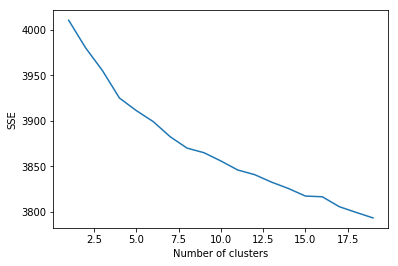

In [35]:
error = np.zeros(20)
for k in range(1,20):
    kmeans = sk_cluster.KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(X_std)
    error[k] = kmeans.inertia_

plt.plot(range(1, 20),error[1:])
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

### K-Means clustering on handles and hashtags (n_clusters = 6)

In [22]:
kmeans = sk_cluster.KMeans(init='k-means++', n_clusters=6, n_init=10, max_iter=300)  

# n_init: Number of time the k-means algorithm will be run 
# max_iter : int, default: 300

kmeans.fit_predict(X_std)

print ('\n Cluster Centroids')
centroids = kmeans.cluster_centers_
print (centroids)

print ('\nCluster labels')
kmeans_labels = kmeans.labels_
print(kmeans_labels)


print('\n')
error = kmeans.inertia_       #SSE; Sum of squared distances of samples to their closest cluster center.
print ("The total error of the clustering is: ", error)


 Cluster Centroids
[[-3.00190626e-02 -2.91197444e-02 -3.16372230e-02 ... -3.13848802e-02
  -4.10347660e-02 -4.33838725e-02]
 [ 2.88080663e+00 -2.91197444e-02 -3.16372230e-02 ... -3.13848802e-02
  -4.10347660e-02  1.96854321e+00]
 [-3.00190626e-02 -2.91197444e-02  2.05088298e+01 ... -3.13848802e-02
  -4.10347660e-02  5.99239739e+00]
 [ 1.66078668e-01  1.95071635e-01  2.15466140e-01 ...  3.11800526e-01
   3.66754310e-01  3.63237181e-01]
 [-6.12959940e-03 -5.55649217e-03 -1.60543967e-02 ... -8.89973762e-03
  -1.04633155e-02 -1.42448645e-02]
 [-3.00190626e-02 -2.91197444e-02 -3.16372230e-02 ... -3.13848802e-02
  -4.10347660e-02 -4.33838725e-02]]

Cluster labels
[4 4 4 ... 4 4 4]


The total error of the clustering is:  67192361.65503632


In [23]:
print(kmeans.cluster_centers_)
asc_order_centroids = kmeans.cluster_centers_.argsort()    # argsort() returns the indices that would sort an array.
print(asc_order_centroids)

des_order_centroids = asc_order_centroids[:,::-1]     #  get the indices in descending order
print(des_order_centroids)

[[-3.00190626e-02 -2.91197444e-02 -3.16372230e-02 ... -3.13848802e-02
  -4.10347660e-02 -4.33838725e-02]
 [ 2.88080663e+00 -2.91197444e-02 -3.16372230e-02 ... -3.13848802e-02
  -4.10347660e-02  1.96854321e+00]
 [-3.00190626e-02 -2.91197444e-02  2.05088298e+01 ... -3.13848802e-02
  -4.10347660e-02  5.99239739e+00]
 [ 1.66078668e-01  1.95071635e-01  2.15466140e-01 ...  3.11800526e-01
   3.66754310e-01  3.63237181e-01]
 [-6.12959940e-03 -5.55649217e-03 -1.60543967e-02 ... -8.89973762e-03
  -1.04633155e-02 -1.42448645e-02]
 [-3.00190626e-02 -2.91197444e-02 -3.16372230e-02 ... -3.13848802e-02
  -4.10347660e-02 -4.33838725e-02]]
[[2948 1512  665 ...  204  501 1542]
 [3976 1449 1908 ... 1796 1153 1591]
 [3976 1449 3984 ... 2988 3498 2871]
 [2135 1206 1305 ... 1160 2948 1512]
 [1512 2948 1160 ... 1206 3976 2135]
 [2948 1512  665 ... 2666 2612 2207]]
[[1542  501  204 ...  665 1512 2948]
 [1591 1153 1796 ... 1908 1449 3976]
 [2871 3498 2988 ... 3984 1449 3976]
 [1512 2948 1160 ... 1305 1206 2135

In [24]:
# retrieve top 10 terms in each cluster
terms = vectorizer.get_feature_names()
for i in range(6):
    print ("Cluster:", i)
    for ind in des_order_centroids[i, :10]:
        print (terms[ind])
    print()

Cluster: 0
hockey
canada
arts
birds
baseball
child
team
movies
heart
world

Cluster: 1
huma
fareedzakaria
jerusalem_post
rbcreamer
thebriefing2016
woodhouseb
np
housecracka
jamesokeefeiii
s_c_

Cluster: 2
prolife
termlimits
reinindc
pjnet
jstines3
cosproject
commoncore
petefrt
alllivesmatter
bcwilliams92

Cluster: 3
hillaryclinton
realdonaldtrump
fbi
donaldjtrumpjr
foxnews
cnn
kellyannepolls
washingtonpost
wikileaks
jasoninthehouse

Cluster: 4
lin_manuel
worldseries
flythew
cubs
gbbofinal
innovation
halloweencostume
gbbo
realskipbayless
sbnation

Cluster: 5
maine
ny
oregon
me
alabama
california
wisconsin
va
ca
nh



### Analysis of top terms in each cluster:
##### Cluster 0: television/sports, media
##### Cluster 1: human/civil rights issues
##### Cluster 2: holidays/shopping
##### Cluster 3: Indian politics/journalism
##### Cluster 4: military/veterans, random shit
##### Cluster 5: 2016 Election / US Govt. & Politics <---

### SSE-based agglomerative clustering on handles and hashtags (n_clusters = 6)

In [25]:
df_hashtags_ag = df_idx_id.transpose()
# normalize values along the rows
X_normalized = preprocessing.normalize(df_hashtags_ag)

ag = sk_cluster.AgglomerativeClustering(linkage='ward', n_clusters=6)   

ag_labels = ag.fit_predict(X_normalized)
ag_labels

array([2, 2, 0, ..., 2, 0, 0])

In [26]:
for i in range(6):
    print("Cluster: ", i)
    for ind in np.nditer(np.where(ag_labels == i)):
        print(terms[ind])
    print("-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-\n")

Cluster:  0
_cfj_
_makada_
_proud_american
abbymartinm
abc7ny
abcdesignated
adambaldwin
adele
aduanebrown
ag_conservative
agentsergeevna
agpambondi
aiiamericangiri
ajdelgado13
alaskantexanqct
albertbrooks
alecbaldwin
allenwest
alllivesmatter
alwayanamerican
always_trump
america_1st_
american_mirror
americanmex067
americans
americansowoke
amlookout
amymek
andendall
andieiamwhoiam
andreajmarkley
anitadwhite
anncoulter
anomaly1
anthonyvveiner
appsame
arifleischer
arnews1936
asamjulian
asavagenation
atensnut
att
attentionmustbe
auditthemedia
austan_goolsbee
babbsgirl2
bakedalaska
barbmuenchen
baseballcrank
basedmattforney
basketofdeplorables
bcwilliams92
becketadams
beladonnarogers
benhowe
bensasse
berniesanders
bfraser747
biasedmedia
bibi4trump
bigboater88
bigstick2013
bikers4trump
billburton
billclintonisarapist
billhemmer
billkristol
billperiman
billpostmus
bizpacreview
blisstabitha
blocked
bluehand007
bocavista2016
borisep
bosnerdley
bradthor
braveheart_usa
breaking
breaking911
breitba

### Analysis of terms in each cluster:

##### Cluster 0: 2016 Election  
##### Cluster 1: human/civil rights issues  
##### Cluster 2: 2016 Election  
##### Cluster 3: US States  
##### Cluster 4: sports, television, entertainment  
##### Cluster 5: holidays, shopping  

### K-Means and SSE-based Agglomerative clustering comparison
Comparing the two clustering algorithms, we see that both models produced  
clusters about the 2016 election, human/civil rights issues, holidays/shopping,  
and entertainment. Contrasting the two models, we see the k-means model  
produced a cluster about indian politics and cluster for the military while  
the SSE-based agglomerative model produced a cluster just with the names  
of U.S. states. Overall, the k-means clustering model outperformed the  
SSE-based agglomerative clustering model by producing more focused  
clusters and with less overlap of topics between different clusters.


### K-Means clustering on users

In [28]:
temp = df_idx_id.drop([col for col, val in df_idx_id.sum().iteritems() if val > 4000], axis=1, inplace=False)

In [30]:
#normalize and select attributes
df_idx_id_std = preprocessing.normalize(df_idx_id, norm='l2', axis=1)

select = VarianceThreshold(threshold=0.0002)
df_idx_id_select = select.fit_transform(df_idx_id_std)

In [31]:
kmeans = sk_cluster.KMeans(init='k-means++', n_clusters=2, n_init=20)  

means = kmeans.fit_predict(df_idx_id_select)

print ('\n Cluster Centroids')
centroids = kmeans.cluster_centers_
print (centroids)

print ('\nCluster labels')
kmeans_labels = kmeans.labels_
print(kmeans_labels)


print('\n')
error = kmeans.inertia_       #SSE; Sum of squared distances of samples to their closest cluster center.
print ("The total error of the clustering is: ", error)


 Cluster Centroids
[[0.02004345 0.00123158 0.0054746  ... 0.03655021 0.00125211 0.00016135]
 [0.00567812 0.0012242  0.00078956 ... 0.04701323 0.0009099  0.00069385]]

Cluster labels
[1 1 1 ... 1 1 1]


The total error of the clustering is:  11627.092722698546


In [33]:
true_values = pd.read_table('./data/clinton_trump_user_classes.txt', names=['user_id', 'label'])
true_values.set_index('user_id', inplace=True)

t_values = df_idx_id.join(true_values, how='inner')
t_labels = pd.DataFrame(t_values['label'], index = t_values.index)

In [34]:
users = df_idx_id.index
labels = pd.DataFrame(kmeans_labels, index=users)
mean_labels_0 = labels[labels.iloc[:,0]==0]
mean_labels_1 = labels[labels.iloc[:, 0]==1]

mean_cluster_0 = df_idx_id.drop(mean_labels_1.index)
mean_cluster_1 = df_idx_id.drop(mean_labels_0.index)

In [35]:
#Clinton
mean_cluster_0.sum(axis=0).sort_values(ascending=False).head(n=30)

realdonaldtrump    21177
hillaryclinton     17852
foxnews            8353 
cnn                5426 
megynkelly         5317 
fbi                3518 
wikileaks          3208 
maga               3184 
newtgingrich       3052 
seanhannity        2868 
kellyannepolls     2588 
msnbc              2430 
trump              2398 
youtube            2386 
potus              2161 
gop                2091 
draintheswamp      1853 
abc                1662 
washingtonpost     1630 
imwithher          1619 
jasoninthehouse    1555 
cnnpolitics        1500 
nytimes            1472 
mike_pence         1396 
mitchellvii        1361 
speakerryan        1285 
wdfx2eu7           1157 
evan_mcmullin      1142 
hillary            1129 
joyannreid         1119 
dtype: int64

In [36]:
#Trump
mean_cluster_1.sum(axis=0).sort_values(ascending=False).head(n=30)

youtube            13132
trump              6308 
news               5546 
worldseries        5250 
pjnet              4100 
hillaryclinton     3769 
hillary            3546 
cubs               3504 
now                3458 
realdonaldtrump    3374 
quote              3348 
cosproject         3208 
spotify            3094 
download           3059 
cnn                2902 
maga               2745 
tcot               2711 
nowplaying         2661 
lgbt               2490 
halloween          2440 
ebay               2346 
wikileaks          2143 
imwithher          2141 
rallytogether      2136 
fbi                1905 
clinton            1865 
gop                1858 
business           1809 
indians            1793 
reinindc           1714 
dtype: int64

In [37]:
mean_c = metrics.confusion_matrix(t_values['label'].values, means, labels=[0, 1])
mean_c

array([[2327, 5348],
       [1344, 8047]])

In [38]:
#precision for Kmean
mean_precision = metrics.precision_score(t_values['label'].values, means)
mean_precision

0.6007465472191116

In [39]:
#recall for Kmean
mean_recall = metrics.recall_score(t_values['label'].values, means)
mean_recall

0.8568842508785007

In [40]:
#Kmean f score
mean_f_score = metrics.f1_score(t_values['label'].values, means)
mean_f_score

0.7063108926533835

### Agglomerative clustering on users

In [41]:
# Cluster 0 = Trump | Cluster 1 = Hillary
ag = sk_cluster.AgglomerativeClustering(n_clusters = 2, linkage = 'ward')   

#complete: The maximum distances
#n_clusters: The number of clusters to find.

ag_sse = ag.fit_predict(df_idx_id_select)
#ag_sse.labels_

In [42]:
ag_sse_labels = pd.DataFrame(ag_sse, index=users)
sse_labels_0 = ag_sse_labels[labels.iloc[:,0]==0]
sse_labels_1 = ag_sse_labels[labels.iloc[:, 0]==1]

sse_cluster_0 = df_idx_id.drop(sse_labels_1.index)
sse_cluster_1 = df_idx_id.drop(sse_labels_0.index)

In [43]:
#Clinton
sse_cluster_0.max(axis=0).sort_values(ascending=False).head(n=30)

gop                 527
evan_mcmullin       407
speakerryan         370
mittromney          364
megynkelly          281
shepnewsteam        273
danaperino          273
newtgingrich        232
hillaryclinton      218
realdonaldtrump     181
lorettalynch        177
braveheart_usa      152
ingrahamangle       151
maga                149
seanhannity         148
kellyannepolls      143
foxnews             129
cnn                 125
msnbc               123
samsteinhp          121
steph93065          106
therickwilson       102
peggy7172           100
wikileaks           97 
trump               95 
fbi                 93 
mike_pence          88 
guilty              87 
hillaryforprison    86 
sykescharlie        84 
dtype: int64

In [44]:
#Trump
sse_cluster_1.max(axis=0).sort_values(ascending=False).head(n=30)

download        3016
spotify         3016
news            2654
lgbt            2320
now             1717
nowplaying      1492
trump           1349
cosproject      1292
pjnet           1020
biz             993 
vip             957 
music           897 
sales           758 
borisjohnson    721 
youtube         705 
florida         680 
leadership      667 
maine           629 
hillary         616 
us              579 
tcot            573 
markets         570 
gop             561 
watch           551 
clinton         544 
finance         535 
jewelry         523 
law             515 
nypost          506 
newyork         506 
dtype: int64

In [45]:
sse_c = metrics.confusion_matrix(t_values['label'].values, ag_sse, labels=[0, 1])
sse_c

array([[7363,  312],
       [9181,  210]])

From this confusion matrix, cluster 0 represents Hilary followers while cluster 1 represents Trump followers

In [46]:
#precision score of ag sse
sse_precision = metrics.precision_score(t_values['label'].values, ag_sse)
sse_precision

0.40229885057471265

In [47]:
#recall score for ag sse
sse_recall = metrics.recall_score(t_values['label'].values, ag_sse)
sse_recall

0.022361835800234268

In [48]:
#f score for ag sse
sse_f_score = metrics.f1_score(t_values['label'].values, ag_sse)
sse_f_score

0.042368606879854734

In [49]:
ag = sk_cluster.AgglomerativeClustering(n_clusters = 2, linkage = 'complete')
ag_max = ag.fit_predict(df_idx_id_select)

ag_max_labels = pd.DataFrame(ag_max, index=users)
max_labels_0 = ag_max_labels[labels.iloc[:,0]==0]
max_labels_1 = ag_max_labels[labels.iloc[:, 0]==1]

In [50]:
max_cluster_0 = df_idx_id.drop(max_labels_1.index)
max_cluster_1 = df_idx_id.drop(max_labels_0.index)

In [51]:
#Trump
max_cluster_0.max(axis=0).sort_values(ascending=False).head(n=30)

gop                 527
evan_mcmullin       407
speakerryan         370
mittromney          364
megynkelly          281
shepnewsteam        273
danaperino          273
newtgingrich        232
hillaryclinton      218
realdonaldtrump     181
lorettalynch        177
braveheart_usa      152
ingrahamangle       151
maga                149
seanhannity         148
kellyannepolls      143
foxnews             129
cnn                 125
msnbc               123
samsteinhp          121
steph93065          106
therickwilson       102
peggy7172           100
wikileaks           97 
trump               95 
fbi                 93 
mike_pence          88 
guilty              87 
hillaryforprison    86 
sykescharlie        84 
dtype: int64

In [52]:
#Clinton
max_cluster_1.max(axis=0).sort_values(ascending=False).head(n=30)

download        3016
spotify         3016
news            2654
lgbt            2320
now             1717
nowplaying      1492
trump           1349
cosproject      1292
pjnet           1020
biz             993 
vip             957 
music           897 
sales           758 
borisjohnson    721 
youtube         705 
florida         680 
leadership      667 
maine           629 
hillary         616 
us              579 
tcot            573 
markets         570 
gop             561 
watch           551 
clinton         544 
finance         535 
jewelry         523 
law             515 
nypost          506 
newyork         506 
dtype: int64

In [53]:
max_c = metrics.confusion_matrix(t_values['label'].values, ag_max, labels=[0, 1])
max_c

array([[7638,   37],
       [9289,  102]])

In [54]:
#precision for ag max
max_precision = metrics.precision_score(t_values['label'].values, ag_max)
max_precision

0.7338129496402878

In [55]:
#recall score for ag max
max_recall = metrics.recall_score(t_values['label'].values, ag_max)
max_recall

0.01086146310297093

In [56]:
#f score for ag max
max_f_score = metrics.f1_score(t_values['label'].values, ag_max)
max_f_score

0.021406086044071355